# Individual Assignment
# Giulia Neves Monteiro

In [1]:
#import os
#os.system ("pip install keras==2.4.3")

!pip install tensorflow

import keras
print('The keras version is {}.'.format(keras.__version__))

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


2025-02-19 03:41:49.482689: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 03:41:49.566724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-19 03:41:53.066349: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


VOC-NOTICE: GPU memory for this assignment is capped at 1024MiB
VOC-NOTICE: GPU memory for this assignment is capped at 1024MiB
The keras version is 2.13.1.


In [2]:
# IPython display functions
import IPython
from IPython.display import display, HTML, SVG, Image

# General Plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [10, 6] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

## notebook style and settings
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))

# For changing background color
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

/tmp/ipykernel_1694/3485464767.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


Library Imports

In [3]:
import os
import sys
import random
import numpy as np
import pandas as pd
from os import walk

# Metrics
from sklearn.metrics import *

# Keras library for deep learning
# https://keras.io/
import tensorflow as tf
import keras
from keras.datasets import mnist # MNIST Data set
from keras.models import Sequential # Model building
from keras.layers import * # Model layers
from keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Helper Functions

## 1.1 Confusion Matrix
Confusion matrices are an important toolkit in every data scientist's box. We created a function  that we can use to create visual confusion matrices and analyze the models.

In [4]:
def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    # Set font size for the plots. You can ignore this line.
    PLOT_FONT_SIZE = 14
    
    # Set plot size. Please ignore this line
    plt.rcParams['figure.figsize'] = [5, 5]
    
    # Transpose of confusion matrix to align the plot with the actual precision recall values. Please ignore this as well.
    confusionMatrix = np.transpose(confusionMatrix)
    
    # Plotting the confusion matrix
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    
    
    # Setting plot properties. You should ignore everything from here on.
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Healthy\nRecall=" + str(recallNegative) , "Pneumonia\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Healthy\nPrecision=" + str(precisionNegative) , "Pneumonia\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
        
    # Add text in heatmap boxes
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap
            
    plt.show()

In [5]:
def calculateMetrics(predictions, predictionsProbabilities, actualLabels):
    # Convert label format from [0,1](label 1) and [1,0](label 0) into single integers: 1 and 0.
    actualLabels = [item[1] for item in actualLabels]
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    try:
        accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
        precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
        precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
        recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
        recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    except:
        print("An exception occurred but was caught.")
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    
    return auc

## 1.2 Metrics Calculation
This function calculates all the metrics we'll need in order to analyze the model

In [6]:
def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    # Convert label format from [0,1](label 1) and [1,0](label 0) into single integers: 1 and 0.
    actualLabels = [item[1] for item in actualLabels]
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    
    # Print metrics. .%2f prints a number upto 2 decimal points only.
    print("------------------------------------------------------------------------")
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    print("------------------------------------------------------------------------")
    
    print("+ Printing confusion matrix...\n")
    # Display confusion matrix
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    
    print("+ Printing ROC curve...\n")
    # ROC Curve
    plt.rcParams['figure.figsize'] = [16, 8]
    FONT_SIZE = 16
    falsePositiveRateDt, truePositiveRateDt, _ = roc_curve(actualLabels, predictionsProbabilities)
    plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 5, color='black')
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
    plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
    plt.show()
    
    return auc

## 1.3 Kaggle Predictions

In [7]:
def getKagglePredictions(model, kaggleData, filename):
    print("+ Writing kaggle test results in : results/%s..." % filename)
    predictions = model.predict(kaggleData)
    predictionProbs = [item[1] for item in predictions]
        
    # Store predictions for kaggle
    outputFile = open("results/" + str(filename), "w")
    outputFile.write("Id,Prediction\n")
    for i in range(0, len(predictionProbs)):
        outputFile.write(str(i + 1) + "," + str(predictionProbs[i]) + "\n")
    
    outputFile.close()

## 1.4 Top n% accuracy

In [8]:
def calculateClasswiseTopNAccuracy(actualLabels, predictionsProbs, TOP_N):
    """
    TOP_N is the top n% predictions you want to use for each class
    """

    discreteActualLabels = [1 if item[1] > item[0] else 0 for item in actualLabels]
    discretePredictions = [1 if item[1] > item[0] else 0 for item in predictionsProbs]
    predictionProbsTopNHealthy, predictionProbsTopNPneumonia = [item[0] for item in predictionsProbs], [item[1] for item in predictionsProbs]
    predictionProbsTopNHealthy = list(reversed(sorted(predictionProbsTopNHealthy)))[:int(len(predictionProbsTopNHealthy) * TOP_N / 100)][-1]
    predictionProbsTopNPneumonia = list(reversed(sorted(predictionProbsTopNPneumonia)))[:int(len(predictionProbsTopNPneumonia) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyHealthy = []
    accuracyPneumonia = []
    for i in range(0, len(discretePredictions)):
        if discretePredictions[i] == 1:
            # Pneumonia
            if predictionsProbs[i][1] > predictionProbsTopNPneumonia:
                accuracyPneumonia.append(int(discreteActualLabels[i]) == 1)
        else:
            # Healthy
            if predictionsProbs[i][0] > predictionProbsTopNHealthy:
                accuracyHealthy.append(int(discreteActualLabels[i]) == 0)

    accuracyHealthy = round((accuracyHealthy.count(True) * 100) / len(accuracyHealthy), 2)
    accuracyPneumonia = round((accuracyPneumonia.count(True) * 100) / len(accuracyPneumonia), 2)
    return accuracyHealthy, accuracyPneumonia

# 2. Data Loading
## 2.1 Loading File Paths
We will first load file paths from normal and pneumonia folders in the train directory.

In [9]:
# Load normal images
normalImagesPath = "data/train/normal"
normalImageFiles = []
for(_,_,files) in walk(normalImagesPath):
    normalImageFiles.extend(files)

normalImagesPath2 = "data/train/normal2"
for(_,_,files) in walk(normalImagesPath2):
    normalImageFiles.extend(files)

print(len(normalImageFiles))

# Load pneumonia images
pneumoniaImagesPath = "data/train/pneumonia"
pneumoniaImageFiles = []
for(_,_,files) in walk(pneumoniaImagesPath):
    pneumoniaImageFiles.extend(files)
    
random.shuffle(pneumoniaImageFiles)
pneumoniaImageFiles = pneumoniaImageFiles[:len(normalImageFiles)]
print("Normal X-ray images: %d\nPneumonia X-ray images: %d" % (len(normalImageFiles), len(pneumoniaImageFiles)))

1436
Normal X-ray images: 1436
Pneumonia X-ray images: 1436


## 2.2 Loading Image Data
### 2.2.1 Training and Validation

In [10]:
imagesData = []
imagesLabels = []

for file in normalImageFiles:
    fullPath = normalImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
        fullPath = normalImagesPath2 + "/" + file
        if os.path.exists(fullPath) == False:
            continue
    imageData = load_img(fullPath, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    imagesData.append(imageArray)
    imagesLabels.append(0)
    

for file in pneumoniaImageFiles:
    fullPath = pneumoniaImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
            continue
            
    imageData = load_img(pneumoniaImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    imagesData.append(imageArray)
    imagesLabels.append(1)

imagesData = np.array(imagesData)
imagesLabels = keras.utils.to_categorical(imagesLabels)
print("Input data shape: %s" % (imagesData.shape,))

#last # is a 1 bc it's colorless
#number of images, and then pixel sizes 256 256. if it was a colored image it would be a 3 instead of 1.

Input data shape: (2872, 256, 256, 1)


In [11]:
"""
from zipfile import ZipFile
file_name = "data/test.zip"

# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall("data/") 
    print('Done!')
"""

'\nfrom zipfile import ZipFile\nfile_name = "data/test.zip"\n\n# opening the zip file in READ mode \nwith ZipFile(file_name, \'r\') as zip: \n    # printing all the contents of the zip file \n    zip.printdir() \n  \n    # extracting all the files \n    print(\'Extracting all the files now...\') \n    zip.extractall("data/") \n    print(\'Done!\')\n'

### 2.2.2 Kaggle Testing Data

In [12]:
testImagesPath = "data/test/"
testImageFiles = []
for(_,_,files) in walk(testImagesPath):
    testImageFiles.extend(files)
testImageFiles = list(sorted(testImageFiles))
    
kaggleTestImages = []
for file in testImageFiles:
    fullPath = testImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
        continue
    imageData = load_img(testImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    kaggleTestImages.append(imageArray)
    
kaggleTestImages = np.array(kaggleTestImages)
print("Number of test images: %d" % len(kaggleTestImages))

Number of test images: 200


## 2.3 Data Splitting into Training and Validation

In [13]:
def trainTestSplit(data, labels):
    """
    80-20 train-test data split
    """
    trainData, trainLabels, testData, testLabels = [], [], [], []
    for i in range(0, len(data)):
        if i % 5 == 0:
            testData.append(data[i])
            testLabels.append(labels[i])
        else:
            trainData.append(data[i])
            trainLabels.append(labels[i])
            
    return np.array(trainData), np.array(testData), np.array(trainLabels), np.array(testLabels)

# splitting the training split 

In [14]:
# In our context, since we have a private test data on kaggle, our test data here would actually mean validation data. We will use results on this validation(test) data to see how our model would perform on the actual test data.
# Split data into 80% training and 20% testing
trainData, testData, trainLabels, testLabels = trainTestSplit(imagesData, imagesLabels)

# 3. Deep Learning Models
We will use keras to create deep learning models. Since we are dealing with images, we will use convolutional layers. For more details, please visit: https://keras.io/layers/convolutional/


## 3.1 Parameterized Convolutional Neural Networks
We  first provide a simple function that takes in a few parameters and create a convolutional neural network model. This is the easiest way to create a CNN model.

In [15]:
def createParameterizedConvolutionalNeuralNetwork(trainImages, numLayers, numFilters, kernelSize, maxPooling, dropoutValue, learningRate, numClasses):
    # Create model object
    model = Sequential()
    
    # Add the first layer with dropout
    model.add(Conv2D(numFilters, kernel_size=(kernelSize, kernelSize),
                       activation='relu', padding = 'same',
                     input_shape=trainImages.shape[1:]))
    model.add(MaxPooling2D(pool_size=(maxPooling, maxPooling)))
    model.add(Dropout(dropoutValue))
    
    while numLayers > 1:
        model.add(Conv2D(numFilters, kernel_size=(kernelSize, kernelSize),
                     activation='relu', padding = 'same'))
        model.add(MaxPooling2D(pool_size=(maxPooling, maxPooling)))
        model.add(Dropout(dropoutValue))
        
        numLayers = numLayers - 1
        
    # Convolutional layers are done, adding the remaining stuff. Please note that after conv layers, you should always use a Flatten() layer.
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropoutValue))
    model.add(Dense(numClasses, activation='softmax'))

    # Compile model. You can skip this line.
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=learningRate),
                  metrics=['accuracy'])
    
    # Return model
    return model

## 3.2 More Nuanced Convolutional Neural Networks
In this section, we provide a function where we can edit tiny details of the model to see if it can give us a greater lift as compared to the parameterized model.

In [16]:
def createNuancedConvolutionalNeuralNetwork(trainImages, numClasses):
    """
    You should try to edit this model as much as you can. Try adding/removing layers, setting different parameters for different layers etc. You have complete control of the model and you should try different things to see what works and what does not.
    """
        # Create model object
    model = Sequential()
    
    # Add the first layer with dropout
    model.add(Conv2D(filters = 64, kernel_size=(5, 5), # # of filters 64. ===== this example inthe code we have 3 layers. we have max pooling etc
                     activation='relu', padding = 'same',
                     input_shape=trainImages.shape[1:]))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    
    # Second layer with different parameters
    model.add(Conv2D(filters = 32, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Third layer with different parameters
    model.add(Conv2D(filters = 32, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Convolutional layers are done, adding the remaining stuff. Please note that after conv layers, you should always use a Flatten() layer.
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))

    # Compile model. You can skip this line.
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])
    
    # Return model
    return model

# 4. Model Training
## 4.1 Data Augmentation
Deep learning models require huge amounts of data for good performance. Since we only have around 5k examples, we will use what's called "Data Augmentation" to create more data. To read more on data augmentation, please visit: https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9

In [17]:
set_background('#fce53a')

#t first try without data augmentation to start simpler

#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################

# You can change all these parameters for different results. Please go to the following links to read more about each parameter: 
# https://keras.io/preprocessing/image/
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
dataAugmentation = ImageDataGenerator(
    rotation_range=12, #20
    width_shift_range=0.05, #0.2
    height_shift_range=0.05, #0.2
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.15, #0.2
    zoom_range=0.15)#0.2

## 4.2 Model Parameters

In [18]:
set_background('#fce53a')

## start here

#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################
numLayers = 3 # Number of layers in the neural network #3
numFilters = 64 # Number of units in each layer #### make them higher #64
kernelSize = 5 # filter size of a single filter #3 or 5
dropoutValue = 0.3 # Dropout probability  #0.3 
maxPooling = 2 # Max pooling #### 3 is very agressive, are shrinking it a lot 
numClasses = 2 # Don't change this value for pneumonia since we have 2 classes i.e we are trying to recognize a digit among 10 digits. But for any other data set, this should be changed
batchSize = 32 # How many images should a single batch contain  
learningRate = 0.0001 # How fast should the model learn #0.0001
epochs = 25 # Number of epochs to train your model for #25 to 30 so it keeps on learning. but might overfit
USE_DATA_AUGMENTATION = True # You can set it to false if you do not want to use data augmentation. We recommend trying both true and false. ### if turn to true will run the augmentation #TRUE
#####################################################################################################################################################


# Please do not change this line.
dataAugmentation.fit(trainData) # Training the augmentor in case we set USE_DATA_AUGMENTATION to True.

## 4.3 Training and Validation

### 4.3.1 Model Instantiation

In [19]:
# Create model
### will create both modles, we have to tell it which to use 
parameterizedModel = createParameterizedConvolutionalNeuralNetwork(trainData, numLayers, numFilters, kernelSize, maxPooling, dropoutValue, learningRate, numClasses = 2)
print("+ Your parameterized model has been created...")

+ Your parameterized model has been created...


In [20]:
# You can create the other model with the following line
nonParameterizedModel = createNuancedConvolutionalNeuralNetwork(imagesData, numClasses = 2)
print("+ Your non parameterized model has been created...")

+ Your non parameterized model has been created...


In [21]:
#####################################################################################################################################################
# Things you can change                                                                                                                             
#####################################################################################################################################################

# Please assign model the deep learning model you want to use i.e parameterizedModel or nonParameterizedModel
model = parameterizedModel ########telling it if we are using the parametized or not model. or change ot the nonParametized Model.
#rec to start with parametized. dont add data augmentation, then start building it up 

#pay attention

### 4.3.2 Model Training and Validation

/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


+ Starting training. Each epoch can take about 2-5 minutes, hold tight!
-----------------------------------------------------------------------

71/71 - 91s - loss: 0.7347 - accuracy: 0.5943 - 91s/epoch - 1s/step
18/18 [==============================] - 6s 345ms/step
+ Test accuracy at epoch 0 is: 74.09 
+ Test AUC at epoch 0 is: 83.260 
+ Writing kaggle test results in : results/epoch-0-results.csv...
7/7 [==============================] - 3s 405ms/step


72/72 - 118s - loss: 0.4654 - accuracy: 0.7841 - 118s/epoch - 2s/step
18/18 [==============================] - 8s 443ms/step
+ Test accuracy at epoch 1 is: 77.74 
+ Test AUC at epoch 1 is: 94.250 
+ Writing kaggle test results in : results/epoch-1-results.csv...
7/7 [==============================] - 3s 379ms/step




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 123s - loss: 0.4593 - accuracy: 0.7915 - 123s/epoch - 2s/step
18/18 [==============================] - 6s 344ms/step
+ Test accuracy at epoch 2 is: 81.91 
+ Test AUC at epoch 2 is: 94.580 
+ Writing kaggle test results in : results/epoch-2-results.csv...
7/7 [==============================] - 3s 383ms/step


72/72 - 119s - loss: 0.3008 - accuracy: 0.8851 - 119s/epoch - 2s/step
18/18 [==============================] - 8s 453ms/step
+ Test accuracy at epoch 3 is: 90.09 
+ Test AUC at epoch 3 is: 96.490 
+ Writing kaggle test results in : results/epoch-3-results.csv...
7/7 [==============================] - 3s 423ms/step




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 121s - loss: 0.4170 - accuracy: 0.8241 - 121s/epoch - 2s/step
18/18 [==============================] - 8s 456ms/step
+ Test accuracy at epoch 4 is: 84.17 
+ Test AUC at epoch 4 is: 96.800 
+ Writing kaggle test results in : results/epoch-4-results.csv...
7/7 [==============================] - 3s 407ms/step


72/72 - 119s - loss: 0.2578 - accuracy: 0.8942 - 119s/epoch - 2s/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 5 is: 91.48 
+ Test AUC at epoch 5 is: 97.080 
+ Writing kaggle test results in : results/epoch-5-results.csv...
7/7 [==============================] - 1s 203ms/step




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 65s - loss: 0.3496 - accuracy: 0.8542 - 65s/epoch - 905ms/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 6 is: 91.83 
+ Test AUC at epoch 6 is: 97.150 
+ Writing kaggle test results in : results/epoch-6-results.csv...
7/7 [==============================] - 1s 202ms/step


72/72 - 65s - loss: 0.2195 - accuracy: 0.9216 - 65s/epoch - 908ms/step
18/18 [==============================] - 8s 439ms/step
+ Test accuracy at epoch 7 is: 92.17 
+ Test AUC at epoch 7 is: 98.040 
+ Writing kaggle test results in : results/epoch-7-results.csv...
7/7 [==============================] - 3s 409ms/step




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 114s - loss: 0.3280 - accuracy: 0.8690 - 114s/epoch - 2s/step
18/18 [==============================] - 4s 233ms/step
+ Test accuracy at epoch 8 is: 92.00 
+ Test AUC at epoch 8 is: 97.690 


72/72 - 117s - loss: 0.2201 - accuracy: 0.9177 - 117s/epoch - 2s/step
18/18 [==============================] - 8s 469ms/step
+ Test accuracy at epoch 9 is: 93.74 
+ Test AUC at epoch 9 is: 98.440 
+ Writing kaggle test results in : results/epoch-9-results.csv...
7/7 [==============================] - 3s 416ms/step




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 120s - loss: 0.3227 - accuracy: 0.8764 - 120s/epoch - 2s/step
18/18 [==============================] - 8s 470ms/step
+ Test accuracy at epoch 10 is: 91.65 
+ Test AUC at epoch 10 is: 97.750 


72/72 - 116s - loss: 0.1727 - accuracy: 0.9356 - 116s/epoch - 2s/step
18/18 [==============================] - 8s 453ms/step
+ Test accuracy at epoch 11 is: 93.39 
+ Test AUC at epoch 11 is: 98.460 
+ Writing kaggle test results in : results/epoch-11-results.csv...
7/7 [==============================] - 3s 394ms/step




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 120s - loss: 0.3267 - accuracy: 0.8703 - 120s/epoch - 2s/step
18/18 [==============================] - 8s 454ms/step
+ Test accuracy at epoch 12 is: 90.09 
+ Test AUC at epoch 12 is: 97.500 


72/72 - 114s - loss: 0.1694 - accuracy: 0.9391 - 114s/epoch - 2s/step
18/18 [==============================] - 8s 453ms/step
+ Test accuracy at epoch 13 is: 94.26 
+ Test AUC at epoch 13 is: 98.670 
+ Writing kaggle test results in : results/epoch-13-results.csv...
7/7 [==============================] - 3s 406ms/step




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 119s - loss: 0.2648 - accuracy: 0.8946 - 119s/epoch - 2s/step
18/18 [==============================] - 8s 470ms/step
+ Test accuracy at epoch 14 is: 94.44 
+ Test AUC at epoch 14 is: 98.310 


72/72 - 116s - loss: 0.1395 - accuracy: 0.9491 - 116s/epoch - 2s/step
18/18 [==============================] - 8s 466ms/step
+ Test accuracy at epoch 15 is: 93.04 
+ Test AUC at epoch 15 is: 98.520 




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 122s - loss: 0.3177 - accuracy: 0.8790 - 122s/epoch - 2s/step
18/18 [==============================] - 8s 468ms/step
+ Test accuracy at epoch 16 is: 90.78 
+ Test AUC at epoch 16 is: 98.370 


72/72 - 111s - loss: 0.1324 - accuracy: 0.9499 - 111s/epoch - 2s/step
18/18 [==============================] - 4s 232ms/step
+ Test accuracy at epoch 17 is: 94.44 
+ Test AUC at epoch 17 is: 98.660 




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 115s - loss: 0.2758 - accuracy: 0.8960 - 115s/epoch - 2s/step
18/18 [==============================] - 9s 470ms/step
+ Test accuracy at epoch 18 is: 93.39 
+ Test AUC at epoch 18 is: 98.520 


72/72 - 114s - loss: 0.1268 - accuracy: 0.9521 - 114s/epoch - 2s/step
18/18 [==============================] - 9s 472ms/step
+ Test accuracy at epoch 19 is: 93.39 
+ Test AUC at epoch 19 is: 98.470 




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 119s - loss: 0.2638 - accuracy: 0.9020 - 119s/epoch - 2s/step
18/18 [==============================] - 9s 475ms/step
+ Test accuracy at epoch 20 is: 93.22 
+ Test AUC at epoch 20 is: 98.160 


72/72 - 117s - loss: 0.1230 - accuracy: 0.9543 - 117s/epoch - 2s/step
18/18 [==============================] - 9s 495ms/step
+ Test accuracy at epoch 21 is: 94.09 
+ Test AUC at epoch 21 is: 98.430 




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 118s - loss: 0.2574 - accuracy: 0.9099 - 118s/epoch - 2s/step
18/18 [==============================] - 9s 465ms/step
+ Test accuracy at epoch 22 is: 93.56 
+ Test AUC at epoch 22 is: 98.540 


72/72 - 116s - loss: 0.1049 - accuracy: 0.9643 - 116s/epoch - 2s/step
18/18 [==============================] - 9s 470ms/step
+ Test accuracy at epoch 23 is: 94.44 
+ Test AUC at epoch 23 is: 98.500 




/tmp/ipykernel_1694/1914474915.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),


71/71 - 119s - loss: 0.2513 - accuracy: 0.9129 - 119s/epoch - 2s/step
18/18 [==============================] - 9s 478ms/step
+ Test accuracy at epoch 24 is: 92.52 
+ Test AUC at epoch 24 is: 98.580 


------------------------------------------------------------------------

*** Printing our best validation results that we obtained in epoch 13 ...
------------------------------------------------------------------------
Accuracy: 94.26
PrecisionNegative: 92.93
PrecisionPositive: 95.68
RecallNegative: 95.83
RecallPositive: 92.68
AUC Score: 98.67
------------------------------------------------------------------------
+ Printing confusion matrix...



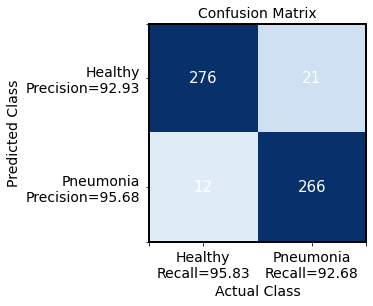

+ Printing ROC curve...



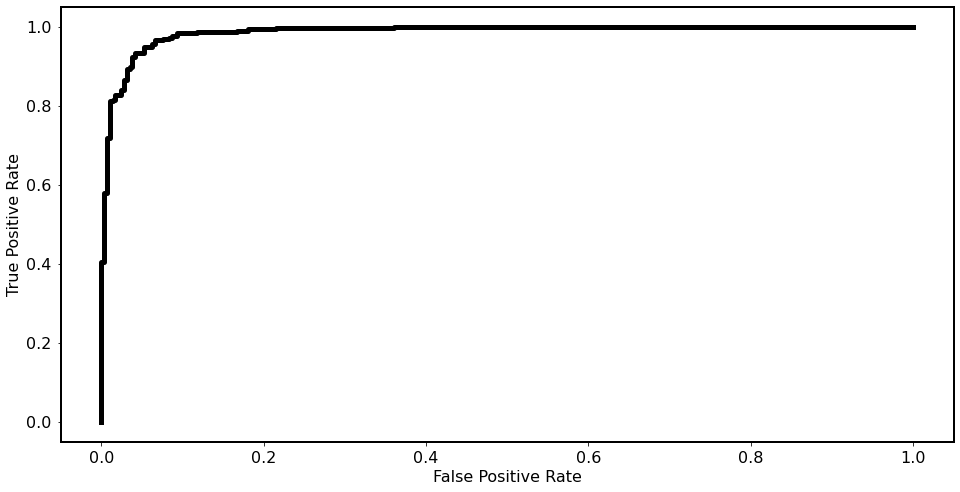

98.67

In [22]:
bestAcc = 0.0
bestEpoch = 0
bestAUC = 0
bestAccPredictions, bestAccPredictionProbabilities = [], [] 

print("+ Starting training. Each epoch can take about 2-5 minutes, hold tight!")
print("-----------------------------------------------------------------------\n")
for epoch in range(epochs):
    
    #################################################### Model Training ###############################################################
    if USE_DATA_AUGMENTATION == True:
        # Use data augmentation in alternate epochs
        if epoch % 2 == 0: #its checking if the epoch # is even, then we use the data augmentation. = its flipping data augmentation on and off between epochs - maybe the best way to do it or not, can play with it. if u change to 3, it will only happen every 3rd. 1 will run all the time
            # Alternate between training with and without augmented data. Training just on the augmented data might not be the best way to go.
            ############ You can change the "epoch % 2" to some other integer value to train on top of the augmented data 
            ############ after a certain number of epochs e.g "epoch % 3" will train on augmented data after every 2 epochs ############
            model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),
                        steps_per_epoch=len(trainData) / batchSize, epochs=1, verbose = 2)
        else:
            model.fit(trainData, trainLabels, batch_size=batchSize, epochs=1, verbose = 2)
    else:
        # Do not use data augmentation
        model.fit(trainData, trainLabels, batch_size=batchSize, epochs=1, verbose = 2)
    
    
    #################################################### Model Testing ###############################################################
    # Calculate test accuracy
    accuracy = round(model.evaluate(testData, testLabels)[1] * 100, 3)
    predictions = model.predict(testData)
    AccPredictionProbabilities = model.predict(testData)
    AccPredictions = [1 if item[1] > item[0] else 0 for item in AccPredictionProbabilities]
    epochAUC = calculateMetrics(AccPredictions, AccPredictionProbabilities, testLabels) ######so we know what the AUC is, since in kaggle is looking at the AUC score instead of accuracy
    print("+ Test accuracy at epoch %d is: %.2f " % (epoch, accuracy))
    print("+ Test AUC at epoch %d is: %.3f " % (epoch, epochAUC))
    outputFile = open("results/Log.txt", "a")
    outputFile.write("Epoch-Accuracy-AUC \t %d \t %.2f \t %.3f \n" % (epoch, accuracy,epochAUC))
    outputFile.close()
    
    if epochAUC > bestAUC: #even if high accuracy, may have higher auc it performs better. 
    #accuracy > bestAcc: # we are keeping track of the best accuracy. which epoch is giving us the best 
        bestEpoch = epoch
        bestAcc = accuracy
        bestAUC = epochAUC #AUC for this is a better metric, u dont want it to overfit. better metric to measure 
        bestAccPredictions = [1 if item[1] > item[0] else 0 for item in predictions]
        bestAccPredictionProbabilities = predictions
        
        ##################################### Store predictions for kaggle ###########################################################
        kaggleResultsFileName = "epoch-" + str(epoch) + "-results.csv" # writes the epoch file to the result folder. 
        ###the files only get written if the value are better than our current one. if its worst it wontcreate the file
        getKagglePredictions(model, kaggleTestImages, kaggleResultsFileName)
        ##############################################################################################################################
    print('\n')
print("------------------------------------------------------------------------")


##################################################### Printing best metrics ##########################################################
# Get more metrics for the best performing epoch
print("\n*** Printing our best validation results that we obtained in epoch %d ..." % bestEpoch)
calculateMetricsAndPrint(bestAccPredictions, bestAccPredictionProbabilities, testLabels)

## 4.4 Top n% Predictions

+ Accuracy for top 5 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 10 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 20 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 30 percent predictions for healthy: 100.00, pneumonia: 98.83


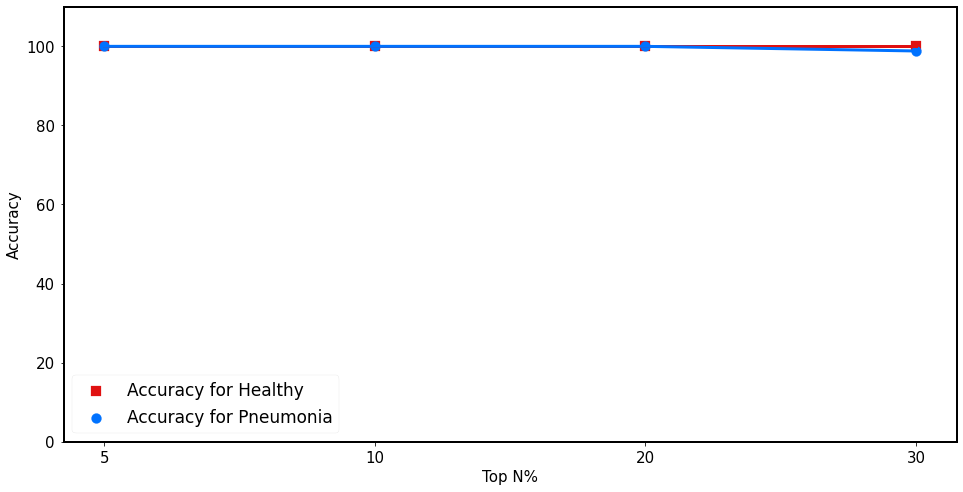

In [23]:
################################## You can change values inside the following list ###########################
topNValues = [5, 10, 20, 30] #### could change these  if ur confusion matrix is being ..
##############################################################################################################

accuraciesHealthy, accuraciesPneumonia = [], []
for topn in topNValues:
    accuracyHealthy, accuracyPneumonia = calculateClasswiseTopNAccuracy(testLabels, bestAccPredictionProbabilities, topn)
    accuraciesHealthy.append(accuracyHealthy)
    accuraciesPneumonia.append(accuracyPneumonia)
    
    print("+ Accuracy for top %d percent predictions for healthy: %.2f, pneumonia: %.2f" % (topn, accuracyHealthy, accuracyPneumonia))
    
# Plot results
x = np.arange(len(accuraciesHealthy))
plt.plot(x, accuraciesHealthy, linewidth = 3, color = '#e01111')
scatterHealthy = plt.scatter(x, accuraciesHealthy, marker = 's', s = 100, color = '#e01111')
plt.plot(x, accuraciesPneumonia, linewidth = 3, color = '#0072ff')
scatterPneumonia = plt.scatter(x, accuraciesPneumonia, marker = 'o', s = 100, color = '#0072ff')
plt.xticks(x, topNValues, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Top N%", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend([scatterHealthy, scatterPneumonia], ["Accuracy for Healthy", "Accuracy for Pneumonia"], fontsize = 17)
plt.ylim(0, 110)
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2da7edf6-dcd9-4d26-8af1-b990b67baf63' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>